This is the document used to make all plots in our paper "Phase transition to coexistence in Class II transposon ecosystems." Please feel free to poke around with different parameter values in Part 3. If it throws any errors with regards to the saving of plots, you can comment those lines out.

In [9]:
from yomportz import *

universal_figure_width = 5

PART ONE: Phase plot

In [38]:
def truly_infinite_sim(starter_means, alpha, omega, decay, jump_kill, T, dt = .01, verbose = True):
    # dead. simple.
    # and posase is measured in units such that it has 50% effect in michaelis or whatever.
    n = len(omega)
    if not ( n == len(alpha) == len(decay) ):
        raise Exception('miss')

    lambdas = 2 * zeros((n, T))
    lambdas[:, 0] = starter_means

    # simulation part
    t = linspace(0, (T - 1) * dt, T)
    for i in range(T - 1):
        if verbose :
            xbar(i / T)

        A = alpha @ lambdas[:, i]
        Omega = omega @ lambdas[:, i]
        MM_factor = 1 / (1 + A)
        
        dlogdt = ( alpha * (omega + Omega) - jump_kill * omega * A ) * MM_factor - decay 

        lambdas[:, i+1] = lambdas[:, i] * exp(dlogdt * dt)
    
    if verbose :
        fig, ax = plt.subplots()
        ax.semilogy(t, lambdas.T)
        plt.show()
    
    return t, lambdas

def plot_phases_2(q, L, T, dt):
    # so this plots the total number of transposons after T steps
    # params of form (alpha_A, alpha_N, r_A, r_N, q)
    # using alpha_A * alpha_N = 1
    # using r_A * r_N = 10**-4
    # A = alpha_A / alpha_N
    # R = r_A / r_N

    A_prod = 1
    R_prod = 10**-4
    A = logspace(-2, 1, L)
    R = logspace(-2, 1, L)
    params = [[tuple() for i in range(L)] for j in range(L)]
    final_tots = zeros((L, L))
    #final_auts = zeros((L, L))
    #final_nons = zeros((L, L))
    #final_rats = zeros((L, L))
    #fp_tots = zeros((L, L))
    for i in range(L):
        xbar(i / L)
      
        for j in range(L):
            
            alpha_A = sqrt(A[i] * A_prod)
            alpha_N = sqrt(A_prod / A[i])
            r_A = sqrt(R[j] * R_prod)
            r_N = sqrt(R_prod / R[j])
            params[i][j] = (alpha_A, alpha_N, r_A, r_N, q)

            alpha = array([alpha_N, alpha_A])
            decay = array([r_N, r_A])
            omega = array([0, 1])
            starter_means = ones(2)

            t, lambdas = truly_infinite_sim(starter_means, alpha, omega, decay, q, T, dt, verbose = False)
            
            final_tots[i, j] = np.sum(lambdas[:, -1])
            #fp_tots[i, j] = np.sum(fp2(*params[i][j]))
            #final_nons[i, j] = lambdas[0, -1]
            #final_auts[i, j] = lambdas[1, -1]
            #final_rats[i, j] = lambdas[0, -1] / lambdas[1, -1]

            
    # rectify infinities
    BIG = 10**4
    final_tots = nan_to_num(final_tots, nan = BIG)
    final_tots = np.clip(final_tots, 1 / BIG, BIG)
    #fp_tots = nan_to_num(fp_tots, nan = BIG)
    #fp_tots = np.clip(fp_tots, 1 / BIG, BIG)

    # curve where equality occurs
    # A = R + q w / r_N
    A_eq = R + q / sqrt(R_prod / R)

    X, Y = np.meshgrid(R, A)

    # Create a figure and axis
    fig, ax = plt.subplots(constrained_layout = True)
    fig.set_size_inches(universal_figure_width, .75 * universal_figure_width)

    # Plot the values
    c = ax.pcolormesh(X, Y, final_tots, shading='auto', cmap='viridis', norm=mpc.LogNorm())
    ax.plot(R, A_eq, '--')
    ax.plot(R, ones(L), '--')

    # Set the axes to logarithmic scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(R.min(), R.max())
    ax.set_ylim(A.min(), A.max())

    # Add a color bar and label it
    colorbar = fig.colorbar(c, ax=ax)
    colorbar.set_label('$\\lambda_a(\\infty) + \\lambda_n(\\infty)$')  # Set the label for the colorbar

    # Add labels and title
    ax.set_xlabel('$ r_a / r_n $')
    ax.set_ylabel('$ \\alpha_a / \\alpha_n $')
    #ax.set_title('Long-time limit of helitron count')

    # Show the plot
    plt.show()

    my_savefig(fig, 'phase_plot')

    return params, final_tots

C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3783922099.py:17: RuntimeWarning: overflow encountered in matmul
  A = alpha @ lambdas[:, i]
C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3783922099.py:21: RuntimeWarning: invalid value encountered in multiply
  dlogdt = ( alpha * (omega + Omega) - jump_kill * omega * A ) * MM_factor - decay


C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3783922099.py:23: RuntimeWarning: overflow encountered in multiply
  lambdas[:, i+1] = lambdas[:, i] * exp(dlogdt * dt)
C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3783922099.py:21: RuntimeWarning: invalid value encountered in subtract
  dlogdt = ( alpha * (omega + Omega) - jump_kill * omega * A ) * MM_factor - decay


C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3783922099.py:21: RuntimeWarning: overflow encountered in multiply
  dlogdt = ( alpha * (omega + Omega) - jump_kill * omega * A ) * MM_factor - decay


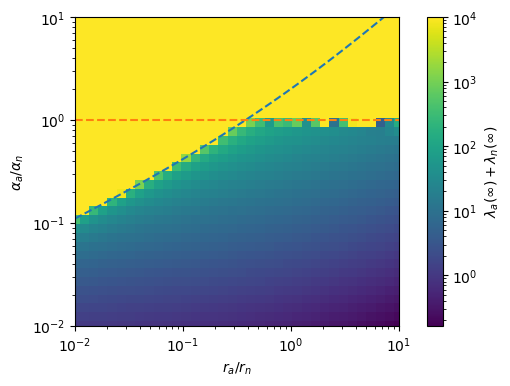

In [39]:
T = 10**4
L = 36
dt = 1
q = .01
o = plot_phases_2(q, L, T, dt)

PART TWO: Multi-strain dynamics

In [12]:
def teeny_plot(half_n, T, dt):
    n = 2 * half_n
    alpha = rand(n)
    omega = rand(n)
    decay = .01 * rand() * ones(n)
    q = .01 * rand()

    starter_means = ones(n)

    # ensure half the strains are non-autonomous
    omega[:half_n] = 0

    # ensure its stable
    while np.max(alpha[:half_n]) < np.max(alpha[half_n:]):
        alpha = rand(n)

    print('alpha = ', alpha)
    print('omega = ', omega)
    print('r = ', decay)
    print('q = ', q)

    t, lambdas = truly_infinite_sim(starter_means, alpha, omega, decay, q, T, dt, verbose = False)
    
    #### PLOTS

    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(universal_figure_width, .5 * universal_figure_width)

    for i in range(half_n):
        ax.semilogy(t, lambdas[i + half_n, :].T, color = 'k')
        ax.semilogy(t, lambdas[i, :].T, '--', color = 'k')

    ax.set_ylim(10**-10, 10**10)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$\\lambda$')
    ax.legend(['autonomous', 'non-autonomous'])

    plt.show()
    my_savefig(fig, 'teeny')
        



alpha =  [0.51514147 0.88661234 0.45361431 0.0918632  0.38111913 0.74565003]
omega =  [0.         0.         0.         0.24832277 0.12425856 0.77208473]
r =  [0.00304063 0.00304063 0.00304063 0.00304063 0.00304063 0.00304063]
q =  0.009320045748098006


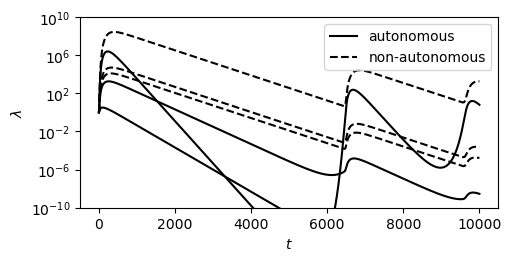

In [13]:
half_n = 3
T = 10**5
dt = .1
teeny_plot(half_n, T, dt)

PART 3: Finite populations sims

Okay so it seems like q = r_A = r_N = .02 is pretty with alpha_A = 1 and  alpha_N = 2.

In [42]:
def approximate_fp2(alpha_A, alpha_N, r_A, r_N, q) :
    denominator = alpha_N * (r_A + q) - alpha_A * r_N
    lambda_A = r_N * alpha_A / denominator
    lambda_N = alpha_A / denominator

    return lambda_N, lambda_A

def fp2(alpha_A, alpha_N, r_A, r_N, q) :
    denominator = alpha_N * (r_A + q) - alpha_A * r_N
    lambda_A = r_N * (alpha_A + q) / denominator
    lambda_N = ( alpha_A * alpha_N - r_A * alpha_N + r_N * alpha_A * (1 - q - alpha_A) ) / alpha_N / denominator

    return lambda_N, lambda_A

def priority_sim(starter_means, alpha, omega, decay, jump_kill, N, TpN):
    # N = number of 
    # T = steps / N, so TpN * N = the number of tasks serviced, roughly similar to the number of deaths probably
    # so its a little weird. omega has units jumps per transposase. a has units transposase per time.
    # and posase is measured in units such that it has 50% effect in michaelis or whatever.
    n = len(omega)
    if not ( n == len(alpha) == len(decay) ):
        raise Exception('miss')
    
    natural_death_rate = 1
    T = TpN * N

    pops = poisson(starter_means.reshape(n, 1), (n, N))

    # begin by making the inital heap. pairs are (time, host_index)
    A = alpha @ pops
    Omega = omega @ pops
    total_jump_rates = A * Omega / (1 + A)
    total_decay_rates = decay @ pops

    total_rates = natural_death_rate + total_jump_rates + total_decay_rates
    rand_times = nra.exponential(1 / total_rates)

    my_heap = list(zip(rand_times, range(N)))
    heapify(my_heap)

    # simulation part
    rand_hold = rand(T)
    rand_hold_exp = nra.exponential(size = T)
    death_count = 0
    jump_count = 0
    decay_count = 0
    time_logr = zeros(T)
    pop_mean_logr = zeros((n, T))
    pop_var_logr = zeros((n, T))
    hold_x = mean(pops, axis = 1)
    hold_xx = mean(pops**2, axis = 1)
    for i in range(T):
        xbar(i / T)
        
        t, host = my_heap[0]
        
        phi = pops[:, host]
        A = alpha @ phi
        Omega = omega @ phi
        jump_rate = A * Omega / (1 + A)
        decay_rate = decay @ phi
        total_rate = natural_death_rate + jump_rate + decay_rate

        hold_x -= phi / N
        hold_xx -= phi**2 / N

        if rand_hold[i] < natural_death_rate / total_rate :
            mom = randint(N)
            dad = randint(N)
            kiddo = binomial(pops[:, mom] + pops[:, dad], .5)
            pops[:, host] = kiddo

            death_count += 1

        elif rand_hold[i] < (natural_death_rate + jump_rate) / total_rate :
            if rand() < jump_kill :
                # for convenience ive done it so it has change to mate before dying, should make sure this is good to first order in 1/N
                mom = randint(N)
                dad = randint(N)
                kiddo = binomial(pops[:, mom] + pops[:, dad], .5)
                pops[:, host] = kiddo
            else:
                rates = alpha * phi * Omega / (1 + A)
                pick = nra.choice(n, p = rates / jump_rate)
                pops[pick, host] += 1

            jump_count += 1

        else:
            rates = decay * phi
            pick = nra.choice(n, p = rates / decay_rate)
            pops[pick, host] -= 1

            decay_count += 1

        # recalculate for next priority
        phi = pops[:, host]
        A = alpha @ phi
        Omega = omega @ phi
        jump_rate = A * Omega / (1 + A)
        decay_rate = decay @ phi
        total_rate = natural_death_rate + jump_rate + decay_rate

        hold_x += phi / N
        hold_xx += phi**2 / N

        new_time = t + rand_hold_exp[i] / total_rate
        heapreplace(my_heap, (new_time, host))

        time_logr[i] = t
        pop_mean_logr[:, i] = hold_x
        pop_var_logr[:, i] = hold_xx - hold_x**2

        EPS = 10**-10
        if np.any(hold_x) < EPS:
            break
    
    print('deaths = ', death_count)
    print('jumps = ', jump_count)
    print('drifts = ', decay_count)
    print('true mean = ', mean(pops, axis = 1), 'recorded mean = ', pop_mean_logr[:, -1])
    print('true var = ', std(pops, axis = 1)**2, 'recorded var = ', pop_var_logr[:, -1])

    # thing for just in case it fails mem
    # my_dump((time_logr, pop_mean_logr, pop_var_logr), 'safenshit')

    # just plots
    N_points = 10**4
    points = linspace(0, T-1, N_points).astype(int)
    t_sub = time_logr[points]
    pop_means = pop_mean_logr[:, points]
    pop_vars = pop_var_logr[:, points]
    
    fig, ax = plt.subplots()
    ax.semilogy(t_sub, pop_means.T)
    ax.semilogy(t_sub, pop_vars.T, '--')
    plt.show()

    # return time_logr, pop_mean_logr, pop_var_logr
    return t_sub, pop_means



In [94]:
def approximate_sigma(alphas, omegas, rs, q, N):
    n = len(alphas)
    if not ( n == len(omegas) == len(rs) ):
        raise Exception('miss')
    
    natural_death_rate = 1

    # dlogdt = A * lambdas + b
    A = alphas.reshape(n, 1) * omegas.reshape(1, n) - (q * omegas + rs).reshape(n, 1) * alphas.reshape(1, n)
    b = alphas * omegas - rs
    
    lambdas_0 = nla.lstsq(A, -b)[0]

    print('fixed point: ', lambdas_0)

    J = ( alphas.reshape(n, 1) * omegas.reshape(1, n) - (q * omegas + rs).reshape(n, 1) * alphas.reshape(1, n) ) * lambdas_0.reshape(n, 1) / (1 + alphas @ lambdas_0)
    Q = natural_death_rate * 2 / N * np.diag(lambdas_0)

    # J S + S J^T + Q = 0
    # M * v = w    [ (J _ +  _ J^T) S = - Q ]

    w = - Q.reshape(n**2)
    M = zeros((n**2, n**2))
    for i in range(n):
        for j in range(n):
            x = zeros((n, n))
            x[i, j] = 1
            thing = J @ x + x @ J.T
            M[:, n * i + j] = thing.reshape(n**2)

    guy = nla.lstsq(M, w)
    print(guy)

    v = guy[0]
    S = v.reshape(n, n)

    print("J:")
    print(J)
    print("Q:")
    print(Q)
    print("S:")
    print(S)

    return lambdas_0, S

def gpt_ellipse(Sigma):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)
    print('bih', eigenvalues)

    a = np.sqrt(eigenvalues[0])
    b = np.sqrt(eigenvalues[1])

    # Rotation angle
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])

    # Parameter t for the ellipse
    t = np.linspace(0, 2 * np.pi, 100)

    # Parametric equation of the ellipse before rotation
    ellipse_param = np.array([a * np.cos(t), b * np.sin(t)])

    # Rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta),  np.cos(theta)]])

    # Rotate the ellipse
    ellipse_rotated = R @ ellipse_param
    
    return ellipse_rotated

def comp_sims(alpha_A, alpha_N, r_A, r_N, q, N, TpN, start_condition = "near" ) :
    # T reps the number of steps in priority queue, not the real time, or the inf steps
    if start_condition == "near" :
        fp_N, fp_A = approximate_fp2(alpha_A, alpha_N, r_A, r_N, q)
        starter_means = array([fp_N, fp_A])
    elif start_condition == "one" :
        starter_means = ones(2)
    else:
        raise Exception('b ashd')
    
    alphas = array([alpha_N, alpha_A])
    rs = array([r_N, r_A])
    omegas = array([0, 1])
    
    center, S = approximate_sigma(alphas, omegas, rs, q, N)

    t, lambdas = priority_sim(starter_means, alphas, omegas, rs, q, N, TpN)

    # overlapping plots
    fig, ax = plt.subplots()
    fig.set_size_inches(universal_figure_width, .8 * universal_figure_width)

    ax.semilogy(t, lambdas.T)
    ax.axhline(center[0], linestyle = '--')
    ax.axhline(center[0] + 2 * sqrt(S[0,0]), linestyle = ':')
    ax.axhline(center[0] - 2 * sqrt(S[0,0]), linestyle = ':')
    ax.axhline(center[1], linestyle = '--', color = '#ff7f0e')
    ax.axhline(center[1] + 2 * sqrt(S[1,1]), linestyle = ':', color = '#ff7f0e')
    ax.axhline(center[1] - 2 * sqrt(S[1,1]), linestyle = ':', color = '#ff7f0e')

    ax.set_xlabel('t (generations)')
    ax.set_ylabel('$\\lambda$')
    ax.legend(['non-autonomous', 'autonomous'])

    plt.show()
    my_savefig(fig, 'dyno')

    ellipse = gpt_ellipse(S)
    ellipse = ellipse + center.reshape(2,1)

    fig, ax = plt.subplots()
    fig.set_size_inches(universal_figure_width, .8 * universal_figure_width)

    if len(t) != 10**4:
        raise Exception('my fancy plot doesnt work anymore, but a simple plot will')
    for i in range(100):
        ax.loglog(lambdas[0,100*i:100*(i+1)], lambdas[1,100*i:100*(i+1)], color = 'k', alpha = .5)
    ax.loglog(ellipse[0, :], ellipse[1, :], '--', color = 'r')
    ax.loglog(center[0], center[1], '+', color = 'r')

    ax.set_xlabel('$\\lambda_n$')
    ax.set_ylabel('$\\lambda_a$')

    plt.show()
    my_savefig(fig, 'swirly')

    return t, lambdas

[0 1]
[2 1]
[0.02 0.02]
0.03
(16.330000000000002, 0.34)
(16.666666666666668, 0.33333333333333337)
fixed point:  [16.33  0.34]
(array([14.03213796,  0.27928522,  0.27928522,  0.01462712]), array([], dtype=float64), 4, array([1.35004391e+00, 1.34044439e+00, 9.61176471e-03, 1.22448916e-05]))
J:
[[-1.92117647e-02  9.50982353e-01]
 [-8.00000000e-04  9.60000000e-03]]
Q:
[[0.00797363 0.        ]
 [0.         0.00016602]]
S:
[[14.03213796  0.27928522]
 [ 0.27928522  0.01462712]]


C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3187327578.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  lambdas_0 = nla.lstsq(A, -b)[0]
C:\Users\nowoy\AppData\Local\Temp\ipykernel_16952\3187327578.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  guy = nla.lstsq(M, w)


 8:46  X                                                      »--X          
deaths =  8756719
jumps =  4197512
drifts =  3822985
true mean =  [0. 0.] recorded mean =  [0. 0.]
true var =  [0. 0.] recorded var =  [0. 0.]


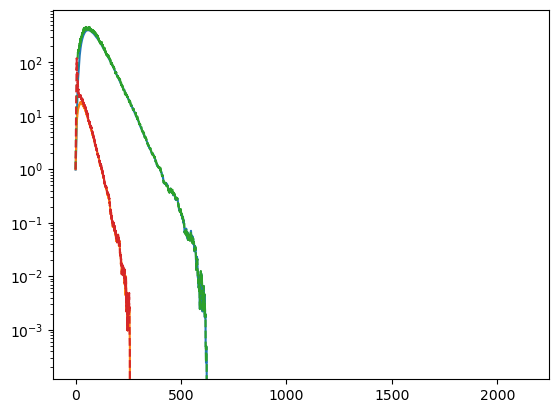

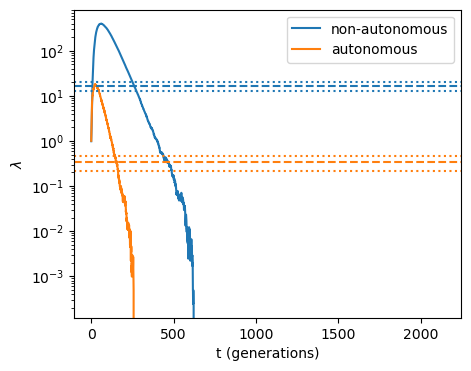

bih [9.06484302e-03 1.40377002e+01]


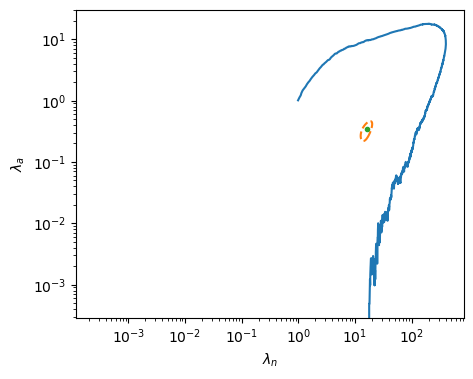

fixed point:  [16.33  0.34]
(array([7.01606898, 0.13964261, 0.13964261, 0.00731356]), array([], dtype=float64), 4, array([1.35004391e+00, 1.34044439e+00, 9.61176471e-03, 1.22448916e-05]))
J:
[[-1.92117647e-02  9.50982353e-01]
 [-8.00000000e-04  9.60000000e-03]]
Q:
[[3.98681641e-03 0.00000000e+00]
 [0.00000000e+00 8.30078125e-05]]
S:
[[7.01606898 0.13964261]
 [0.13964261 0.00731356]]
 1:08:12  X                                                      »--X           
deaths =  49760877
jumps =  9077839
drifts =  8270148
true mean =  [0. 0.] recorded mean =  [0. 0.]
true var =  [0. 0.] recorded var =  [0. 0.]


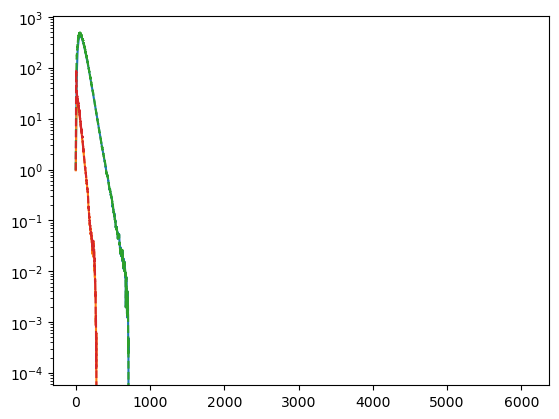

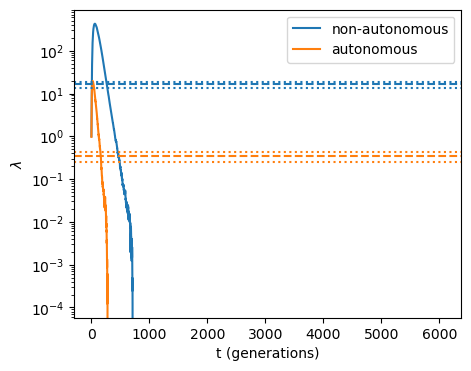

bih [4.53242151e-03 7.01885012e+00]


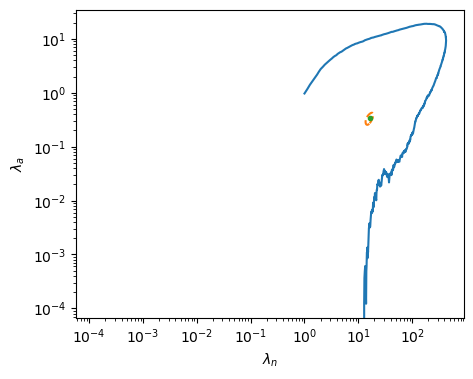

In [36]:
alpha_A = 1 #rand()
alpha_N = 2 #alpha_A + rand()
r_A = .02 #* rand()
r_N = r_A
q = .02 #* rand()

alpha = array([alpha_N, alpha_A])
decay = array([r_N, r_A])
omega = array([0, 1])
print(omega)
print(alpha)
print(decay)
print( (r_A + q) / alpha_A - r_N / alpha_N)
print(fp2(alpha_A, alpha_N, r_A, r_N, q))
print(approximate_fp2(alpha_A, alpha_N, r_A, r_N, q))

N = 4096
TpN = 4400
c, d = comp_sims(alpha_A, alpha_N, r_A, r_N, q, N, TpN, start_condition = 'one')
